In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32


# Directories
data_dir = "Dataset"
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [3]:
# Load and preprocess data
def load_data(data_dir):
    X, Y = [], []
    labels = {'0': 0, '1': 1}  # Folder names 0 and 1 correspond to labels
    for label, idx in labels.items():
        folder = os.path.join(data_dir, label)
        for file in os.listdir(folder):
            if file.endswith('.jpg'):
                img_path = os.path.join(folder, file)
                img = cv2.imread(img_path)
                img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
                X.append(img_resized)
                Y.append(idx)
    return np.array(X), np.array(Y)

In [4]:
X_train, Y_train = load_data(train_dir)
X_valid, Y_valid = load_data(valid_dir)
X_test, Y_test = load_data(test_dir)

# Normalize data
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

# Convert labels to categorical
Y_train = to_categorical(Y_train, 2)
Y_valid = to_categorical(Y_valid, 2)
Y_test = to_categorical(Y_test, 2)

In [5]:
Y_train_labels = np.argmax(Y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_labels),
    y=Y_train_labels
)
class_weights = dict(enumerate(class_weights))

In [6]:
datagen = ImageDataGenerator(
    rotation_range=30,  # Increased rotation
    width_shift_range=0.2,  # Wider shift range
    height_shift_range=0.2,
    zoom_range=0.2,  # Zoom augmentation
    shear_range=0.2,  # Shear transformation
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [7]:

from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)


In [12]:
# Create a validation data generator without augmentation
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(X_valid, Y_valid, batch_size=BATCH_SIZE)

# Train the model with corrected validation data handling
history = model.fit(
   X_train, Y_train, batch_size=32,
    validation_data=(X_train, Y_train),  # Use the generator for validation
    epochs=8,#use 25 first if not getting required output then change 25 as 2 and run from this cell onwards
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 419ms/step - accuracy: 0.8847 - loss: 0.5703 - val_accuracy: 0.9535 - val_loss: 0.4823 - learning_rate: 0.0010
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - accuracy: 0.8957 - loss: 0.5434 - val_accuracy: 0.9652 - val_loss: 0.4451 - learning_rate: 0.0010
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 406ms/step - accuracy: 0.9015 - loss: 0.5286 - val_accuracy: 0.9720 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 4/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 409ms/step - accuracy: 0.8809 - loss: 0.5762 - val_accuracy: 0.9765 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 5/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - accuracy: 0.9072 - loss: 0.5301 - val_accuracy: 0.9788 - val_loss: 0.4274 - learning_rate: 0.0010
Epoch 6/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 405ms/step - accuracy: 0.8842 - loss: 0.6009 - val_accuracy: 0.9822 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 7/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - accuracy: 0.9208 - loss: 0.5298 - 

In [21]:
# Assuming 'model' is your trained model
model.save('my_model.h5')



In [16]:
labels = ['Normal', 'Infected']
def predict_image(image_path):
    image = cv2.imread(image_path)
    img_resized = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    plt.figure(figsize=(6, 4))
    img_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_display)
    plt.title(f"Prediction: {labels[predicted_class]} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

In [22]:
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')
test_loss, test_accurecy = model.evaluate(X_train, Y_train)
print(f"Test Accuracy: {test_accurecy}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9918 - loss: 0.4210
Test Accuracy: 0.9878925681114197


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


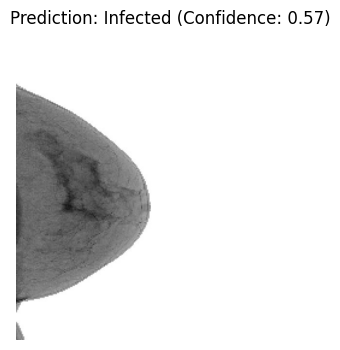

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


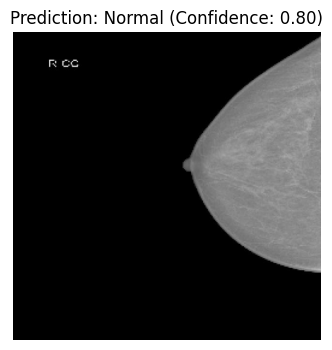

In [18]:
# Example usage of the prediction function
predict_image(r'Dataset\valid\1\1336_1475901500_png.rf.c23cede8de869f9845af5d09a3ca4bf5.jpg')
predict_image(r'Dataset\valid\0\5_940388076_png.rf.b61a6986ef24d48d9dabfdc4a4947ebb.jpg')
